In [1]:
from skimage.transform import resize
from itertools import product
from collections import OrderedDict
from tqdm.notebook import tqdm

import torch
from torch.utils.data import DataLoader
from torchvision import transforms, utils, models
import torch.nn as nn 
import torch.nn.functional as F
import torch.optim as optim

from Run import RunBuilder as RB
from Run import RunManager as RM
from DataLoading import UdacityDataset as UD
from DataLoading import ConsecutiveBatchSampler as CB

from model import Convolution3D as CNN3D

%run Visualization.ipynb

device = torch.device("cuda")
print("Done with Imports")

Done with Imports


In [7]:
import os
train_root = '/home/ortizalejandro93/data/train_data_small/'
csv_file_path = os.path.join(train_root, 'interpolated.csv')
camera_type = 'center_camera'
output_dir = '/home/ortizalejandro93/models/CNN3D_models'

# Model Training / Loading

In [9]:
parameters = OrderedDict(
    file = ['3DCNN_Paper'], # used to mark specific files in case that we want to check them on tensorboard
    learning_rate = [0.001],
    batch_size = [5],
    seq_len = [5],
    num_workers = [2],
)
m = RM.RunManager()

for run in RB.RunBuilder.get_runs(parameters):
    network = CNN3D.Convolution3D().to(device)

    optimizer = optim.Adam(network.parameters(),lr = run.learning_rate,betas=(0.9, 0.999), eps=1e-08, weight_decay=0.001, amsgrad=False)

    udacity_dataset = UD.UdacityDataset(csv_file=csv_file_path,
                                     root_dir=train_root,
                                     transform=transforms.Compose([transforms.ToTensor()]),
                                     select_camera=camera_type)

    dataset_size = int(len(udacity_dataset))
    del udacity_dataset
    split_point = int(dataset_size * 0.8)

    training_set = UD.UdacityDataset(csv_file=csv_file_path,
                                     root_dir=train_root,
                                     transform=transforms.Compose([transforms.ToTensor()]),
                                     select_camera=camera_type,
                                     select_range=(0,split_point))
    validation_set = UD.UdacityDataset(csv_file=csv_file_path,
                                     root_dir=train_root,
                                     transform=transforms.Compose([transforms.ToTensor()]),
                                     select_camera=camera_type,
                                     select_range=(split_point,dataset_size))
    print("size of training set :{}".format(len(training_set)))
    print("size of validation set :{}".format(len(validation_set)))
    m.training_set = training_set
    m.validation_set = validation_set

    training_cbs = CB.ConsecutiveBatchSampler(data_source=training_set, batch_size=run.batch_size, shuffle=True, drop_last=False, seq_len=run.seq_len)
    training_loader = DataLoader(training_set, sampler=training_cbs, num_workers=run.num_workers, collate_fn=(lambda x: x[0]))
    
    validation_cbs = CB.ConsecutiveBatchSampler(data_source=validation_set, batch_size=run.batch_size, shuffle=True, drop_last=False, seq_len=run.seq_len)
    validation_loader = DataLoader(validation_set, sampler=validation_cbs, num_workers=run.num_workers, collate_fn=(lambda x: x[0]))
    
    m.begin_run( run,network,[run.batch_size,3,run.seq_len,120,320] )
    for epoch in range(1): # Was 10 Make this 1 during debugging
        m.begin_epoch()
# Calculation on Training Loss
        for training_sample in tqdm(training_loader, total=int(len(training_set)/run.batch_size/run.seq_len)):
            training_sample['image'] = torch.Tensor(resize(training_sample['image'], (run.batch_size,run.seq_len,3,120,320),anti_aliasing=True))
            training_sample['image'] = training_sample['image'].permute(0,2,1,3,4)
            
            param_values = [v for v in training_sample.values()]
            image,angle = param_values[0],param_values[3]
            image = image.to(device)
            prediction = network(image)
            prediction = prediction.squeeze().permute(1,0).to(device)
            labels = angle.to(device)
            del param_values, image, angle
            if labels.shape[0]!=prediction.shape[0]:
                prediction = prediction[-labels.shape[0],:]
            training_loss_angle = F.mse_loss(prediction,labels.float(),size_average=None, reduce=None, reduction='mean')
            optimizer.zero_grad()# zero the gradient that are being held in the Grad attribute of the weights
            training_loss_angle.backward() # calculate the gradients
            optimizer.step() # finishing calculation on gradient
        print("Done")
# Calculation on Validation Loss
        with torch.no_grad():    
            for Validation_sample in tqdm(validation_loader, total=int(len(validation_set)/run.batch_size/run.seq_len)):
                Validation_sample['image'] = torch.Tensor(resize(Validation_sample['image'], (run.batch_size,run.seq_len,3,120,320),anti_aliasing=True))
                Validation_sample['image'] = Validation_sample['image'].permute(0,2,1,3,4)

                param_values = [v for v in Validation_sample.values()]
                image,angle = param_values[0],param_values[3]
                image = image.to(device)
                prediction = network(image)
                prediction = prediction.squeeze().permute(1,0).to(device)
                labels = angle.to(device)
                del param_values, image, angle
                if labels.shape[0]!=prediction.shape[0]:
                    prediction = prediction[-labels.shape[0],:]
                validation_loss_angle = F.mse_loss(prediction,labels,size_average=None, reduce=None, reduction='mean')
                m.track_loss(validation_loss_angle)
                m.track_num_correct(prediction,labels) 
        #m.end_epoch(validation_set)
        m.end_epoch()
        torch.save(network.state_dict(), os.path.join(output_dir, "CNN3D-epoch-{}".format(epoch)))
    m.end_run()
m.save('result')

,run,epoch,loss,accuracy,epoch duration,run duration,file,learning_rate,batch_size,seq_len,num_workers
0,1,1,0.00047,0.003405,331.696096,331.697752,3DCNN_Paper,0.001,5,5,2


# Load model directly from disk

(64, 3, 3, 3, 3)


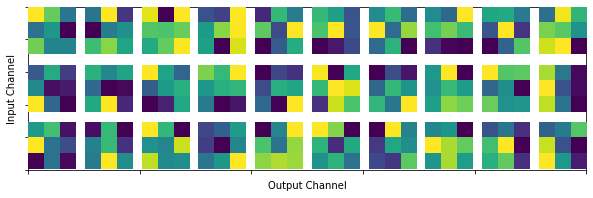

In [12]:
cnn3d_model = CNN3D.Convolution3D().to(device) # CNN3D import
cnn3d_model.load_state_dict(torch.load(os.path.join(output_dir, "CNN3D-epoch-0")))

visualize_cnn(cnn3d_model.Convolution1)

## GradCAM

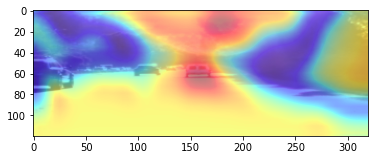

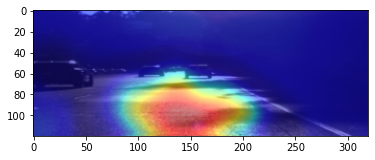

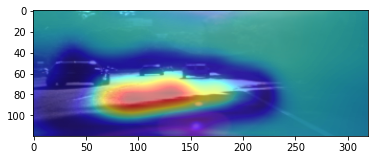

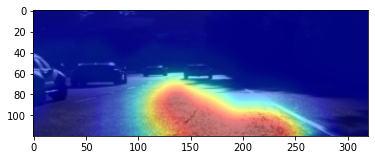

In [16]:
cnn_cam_extractor = CamExtractor3DCNN(cnn3d_model)

Batch_size = 5
Seq_len = 5 

udacity_dataset = UD.UdacityDataset(csv_file=csv_file_path, 
                                    root_dir=train_root,
                                    transform=transforms.Compose([transforms.ToTensor()]),
                                    select_camera=camera_type)

# 3D CNN has different input batch size and seq_len, so we define new CBS and Loader

cbs_3dcnn = CB.ConsecutiveBatchSampler(data_source=udacity_dataset, batch_size=Batch_size, shuffle=False, drop_last=False, seq_len=Seq_len)
loader_3dcnn = DataLoader(udacity_dataset, sampler=cbs_3dcnn, collate_fn=(lambda x: x[0]))

mse_loss = nn.MSELoss()

for i, testing_sample in enumerate(loader_3dcnn):
    testing_sample['image'] = torch.Tensor(resize(testing_sample['image'], (Batch_size,Seq_len,3,120,320),anti_aliasing=True))
    testing_sample['image'] = testing_sample['image'].permute(0,2,1,3,4)
    image = testing_sample['image'].to(device)
    prediction = cnn3d_model(image).squeeze()
    target = testing_sample['angle'].to(device)
    loss = mse_loss(prediction, target.float())
    loss.backward()
    
    plt.figure()
    cam_image = cnn_cam_extractor.to_image(width=320, height=120) # Use this line to extract CAM image from the model!
    plt.imshow(testing_sample['image'][0, :, -1, :, :].permute(1, 2, 0))
    plt.imshow(cam_image[0, -1, :, :], cmap='jet', alpha=0.5)
    
    if i==3: # show only a few for testing
        break